# Programmentwurf
In dieser Aufgabe wollen wir Bilder in 6 verschiedene Klassen klassifizieren: "Häuser, Wald, Gletscher, Berge, Wasser, Straße".

## Laden einiger wichtiger Bibliotheken

In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plot
from random import randint
import random

## Laden weiterer Bibliotheken
Soweit benötigt können natürlich weiter Python-Bibliotheken geladen werden. Bitte diese Bibliotheken im unteren Codeblock einfügen.

In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc,confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2
from keras.layers import  GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model

## Dictionary/Map von Klassenname zu Index
Wir bauen ein Mapping zwischen Klassenlabel und Klassenindex

In [3]:
labelMap = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
keyMap = {v: k for k, v in labelMap.items()}
class_labels = list(labelMap.keys())
print(labelMap)
print(keyMap)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


Methode um Bilder aus einem Verzeichnis zu laden

In [4]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    for dirName in os.listdir(directory):
        #print(dirName)
        label = labelMap[dirName]
        
        for image_file in os.listdir(directory+dirName): 
            image = cv2.imread(directory+dirName+r'/'+image_file) 
            im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if image.shape == (150, 150, 3):
                Images.append(im_rgb)
                Labels.append(label)
    
    return Images,Labels

## Laden der Trainingsdaten
Wir laden die Trainingsdaten aus den angegebenen Zip-Dateien

In [12]:
x_train, Y_train = get_images('Data/train/')

## Konvertiere Bilder in Numpy-Arrays

In [13]:
x_train = np.array(x_train) 
Y_train = np.array(Y_train)

In [20]:
print("Shape of Images:",x_train.shape)
print("Shape of Labels:",Y_train.shape)

Shape of Images: (13986, 150, 150, 3)
Shape of Labels: (13986,)


## Zählen der einzelnen Bildklassen
Für einen ersten Eindruck wollen wir wissen, ob die einzelnen Klassen in etwa gleichverteilt sind.

In [10]:
unique_elements, counts_elements = np.unique(Y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2    3    4    5]
 [2190 2263 2387 2495 2270 2381]]


## Plotten der Daten

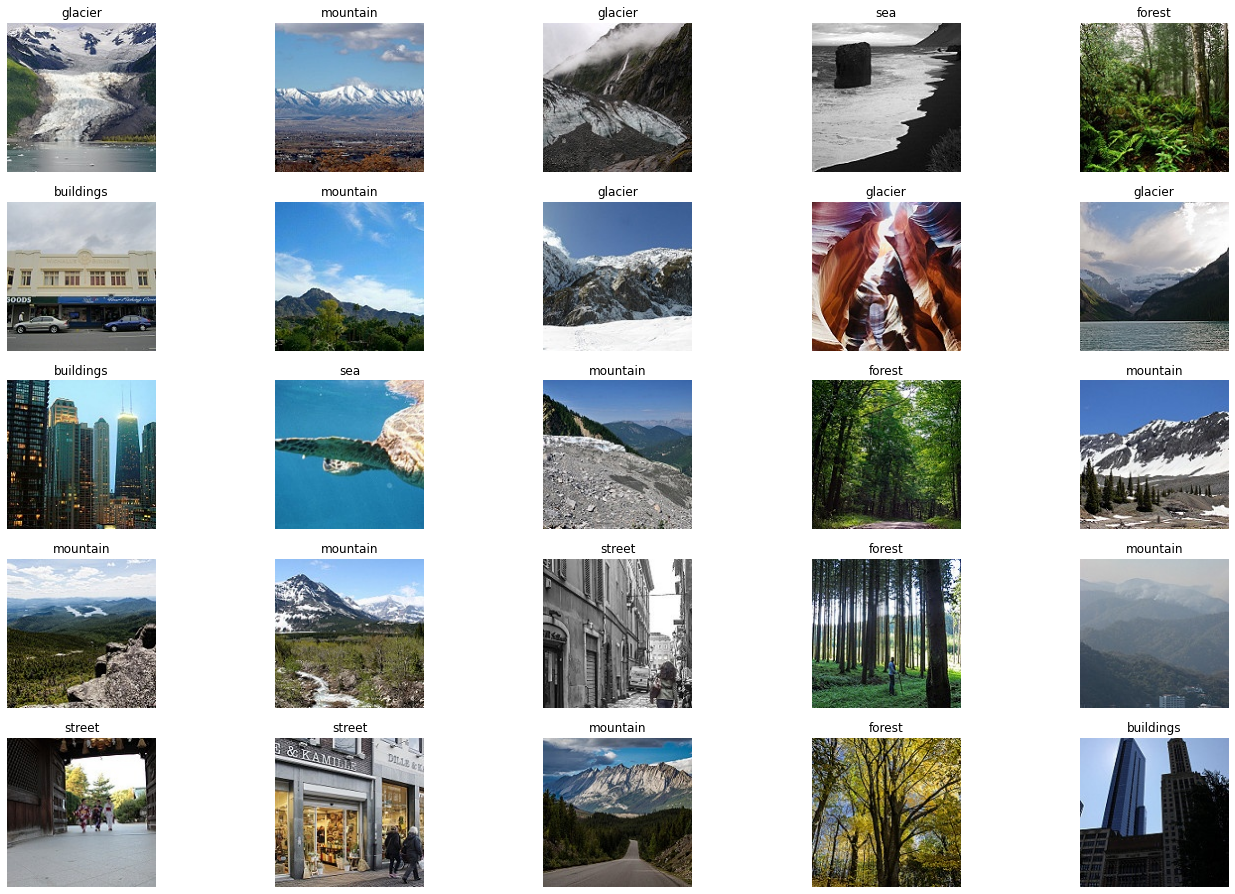

In [11]:
random.seed(1202)
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(x_train))
        ax[i,j].imshow(x_train[rnd_number])
        ax[i,j].set_title(keyMap[Y_train[rnd_number]])
        ax[i,j].axis('off')

## 1.)  Erstellen Sie ein Evaluationsszenario  (5 Punkte)

### 1.1) Erstellen Sie einen stratifizierten Train/Dev-Split (80%-Train / 20%-Dev). 

Zuerst nehmen wir die nach Klassen sortierten Trainingsdaten und Shuffeln sowohl das x_train als auch y_train. Sonst hätte es das Modell nachher denkbar einfach zu erlernen, wann welches Bild kommt, da es einfach die aufsteigende Reihenfolge erlernen könnte. Wichtig ist außerdem, dass x & y mit dem selben seed geshuffelt werden, um zu den Daten auch die richtigen Labels zu erhalten.


In [7]:
x_train, Y_train = shuffle(x_train, Y_train, random_state=0)

Stimmen die Labels noch nach dem Shuffeln?

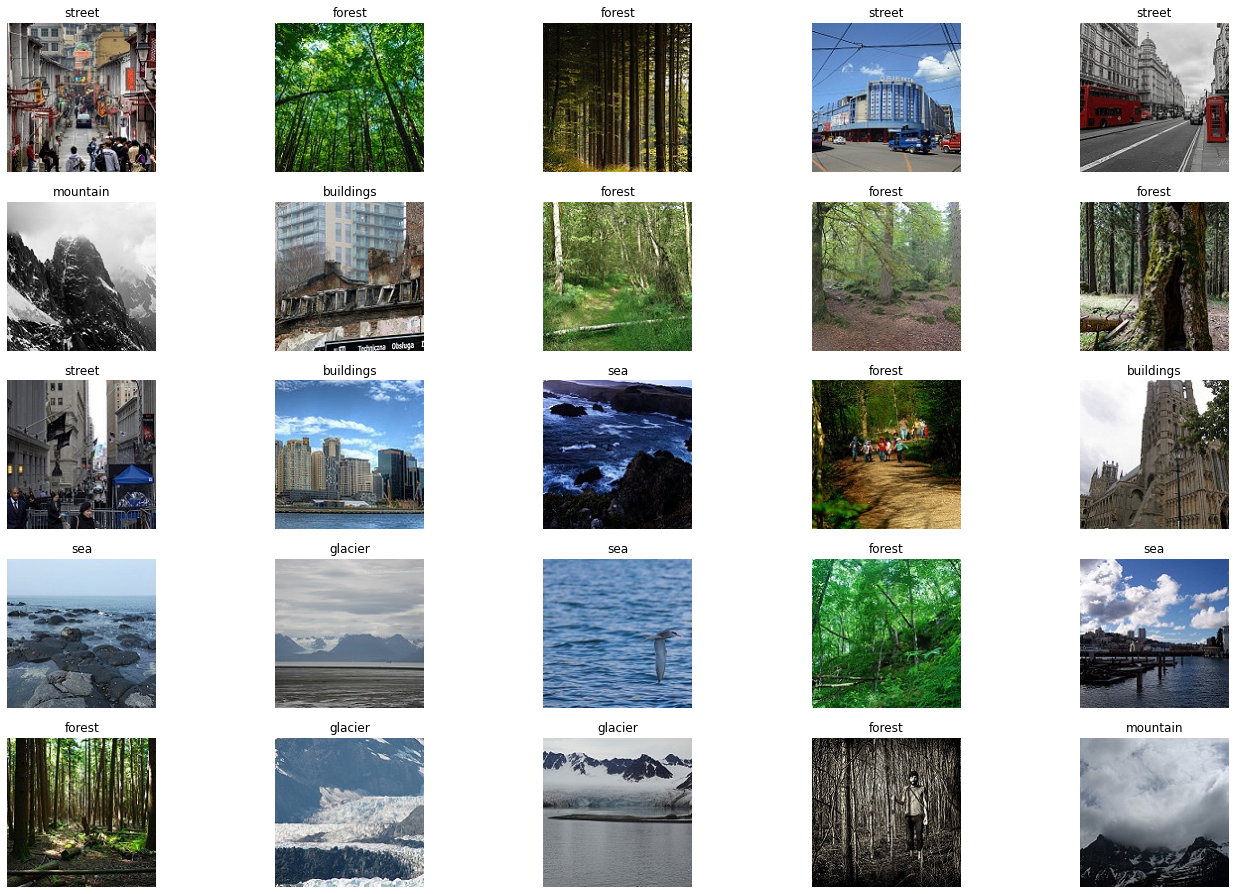

In [16]:
random.seed(1202)
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(x_train))
        ax[i,j].imshow(x_train[rnd_number])
        ax[i,j].set_title(keyMap[Y_train[rnd_number]])
        ax[i,j].axis('off')

Sieht gut aus :) 


Nun können wir einfach die ersten 80% der gemischten Daten als Trainingsdaten verwenden und die restlichen 20% als Dev

In [14]:
x_train_, x_dev_, y_train_, y_dev_ = train_test_split(x_train, Y_train,
                                                   test_size=0.2,
                                                   stratify=Y_train)

### 1.2) Veranschaulichen Sie, dass die Splits wirklich stratifiziert sind


Sind alle Daten in Train und Dev Unterteilt?

In [25]:
all_data_used = x_train_.shape[0]+x_dev_.shape[0] == x_train.shape[0]
all_data_used

True

Ist die Verteilung noch relativ gleich?

In [19]:
unique_elements, counts_elements_org = np.unique(Y_train, return_counts=True)
unique_elements, counts_elements_train = np.unique(y_train_, return_counts=True)
unique_elements, counts_elements_dev = np.unique(y_dev_, return_counts=True)

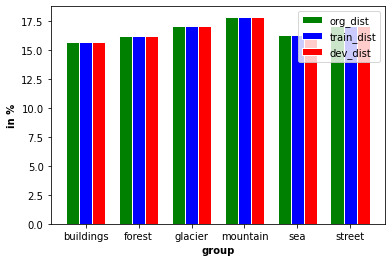

In [ ]:

barWidth = 0.25
bars1 = (counts_elements_org/x_train.shape[0])*100
bars2 = (counts_elements_train/x_train_.shape[0])*100
bars3 = (counts_elements_dev/x_dev_.shape[0])*100
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='var2')
plt.bar(r3, bars3, color='red', width=barWidth, edgecolor='white', label='var3')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.ylabel("in %", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], class_labels)
 
# Create legend & Show graphic
plt.legend(labels=["org_dist","train_dist","dev_dist"])
plt.show()


# Kopiert und angepasst von : https://www.python-graph-gallery.com/11-grouped-barplot

Im oberen Graph sieht man, dass die orginale Verteilung der Daten sehr genau der der Traing & Dev- Splits gleicht

### 1.3) Laden Sie die Testdaten (test.zip) und veranschaulichen Sie deren Verteilung

In [20]:
x_test, Y_test = get_images('Data/test/')
x_test = np.array(x_test) 
Y_test = np.array(Y_test)
print("Shape of Images:",x_test.shape)
print("Shape of Labels:",Y_test.shape)

Shape of Images: (2993, 150, 150, 3)
Shape of Labels: (2993,)


Die Verteilung ist wie folgt:

In [ ]:
unique_elements, counts_elements_test = np.unique(Y_test, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2    3    4    5]
 [2190 2263 2387 2495 2270 2381]]


Die Verteilung der Daten aus dem Train und dem Test Ordner im Vergleich:

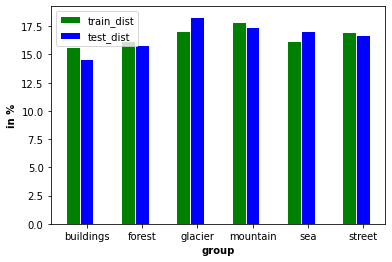

In [ ]:
barWidth = 0.25
bars1 = (counts_elements_org/x_train.shape[0])*100
bars2 = (counts_elements_test/x_test.shape[0])*100

 

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

 

plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='var2')

 

plt.xlabel('group', fontweight='bold')
plt.ylabel("in %", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], class_labels)
 

plt.legend(labels=["train_dist","test_dist"])
plt.show()

# Kopiert und angepasst von : https://www.python-graph-gallery.com/11-grouped-barplot

##  2.) Trainieren Sie eine Baseline  (10 Punkte)

### 2.1) Trainieren Sie (auf den Trainingsdaten) einen Naive Bayes-Klassifikator, welcher alle 6 Bildklassen erkennt. 

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_reshaped = x_train_.reshape(x_train_.shape[0], 150*150*3)
X_train_scaled = scaler.fit_transform(X_train_reshaped) #Skalierung der Pixelwerte auf[0,1]

X_dev_reshaped = x_dev_.reshape(x_dev_.shape[0], 150*150*3)
X_dev_scaled = scaler.fit_transform(X_dev_reshaped) #Skalierung der Pixelwerte auf[0,1]

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

# Create classifiers
clf1 = GaussianNB()
clf2 = BernoulliNB()
clf3 = MultinomialNB()

# Fit classifiers to training data
clf1.fit(X_train_scaled, y_train_)
clf2.fit(X_train_scaled, y_train_)
clf3.fit(X_train_scaled, y_train_)

# Predict on test data
y_pred1 = clf1.predict(X_dev_scaled)
y_pred2 = clf2.predict(X_dev_scaled)
y_pred3 = clf3.predict(X_dev_scaled)

# Compute accuracy scores
acc1 = accuracy_score(y_dev_, y_pred1)
acc2 = accuracy_score(y_dev_, y_pred2)
acc3 = accuracy_score(y_dev_, y_pred3)

# Print results
print("Accuracy for GaussianNB:", acc1)
print("Accuracy for BernoulliNB:", acc2)
print("Accuracy for MultinomialNB:", acc3)

Accuracy for GaussianNB: 0.4749821300929235
Accuracy for BernoulliNB: 0.36812008577555394
Accuracy for MultinomialNB: 0.4410293066476054


### 2.2) Evaluieren Sie diesen Klassifikator auf dem Test-Set (Accuracy)


In [ ]:

X_test_reshaped = x_test.reshape(x_test.shape[0], 150*150*3)
X_test_scaled = scaler.transform(X_test_reshaped)
y_pred = clf1.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, y_pred)
precission = precision_score(Y_test, y_pred,average='macro')
recall = recall_score(Y_test, y_pred,average='macro')
f1_score = f1_score(Y_test, y_pred,average='macro')
print("Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1-Score: {:.3f}".format(accuracy, precission, recall, f1_score))

Accuracy: 0.469, Precision: 0.462, Recall: 0.466, F1-Score: 0.445


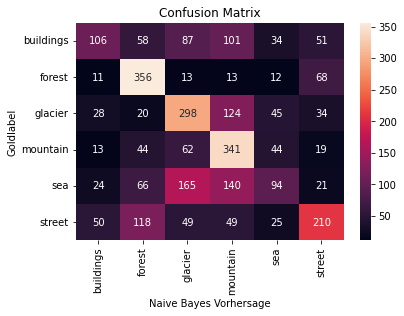

In [ ]:
conf_matrix = confusion_matrix(Y_test, y_pred)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Naive Bayes Vorhersage')
plt.ylabel('Goldlabel')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels,rotation='vertical')
ax.yaxis.set_ticklabels(class_labels,rotation='horizontal')
plt.show()

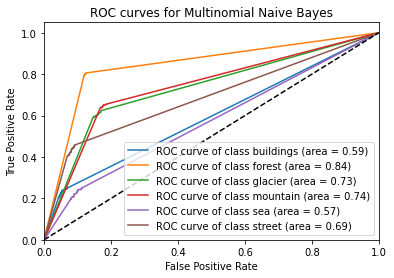

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Use the trained classifier to make predictions on the validation data
y_pred_prob = clf1.predict_proba(scaler.transform(x_dev_.reshape(x_dev_.shape[0], 150*150*3)))

# Compute the ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_dev_, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for Multinomial Naive Bayes')
plt.legend(loc="lower right")
plt.show()

## 3.)  Trainieren Sie ein Neuronales Netz zur Bilderkennung (20 Punke)

### 3.1) Entwickeln Sie ein mehrschichtiges CNN-Model mit Dropout


In [22]:

model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  


model.add(Flatten())


model.add(Dense(len(class_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
from keras.callbacks import ProgbarLogger
from sklearn.preprocessing import StandardScaler

logger = ProgbarLogger()
scaler = StandardScaler()

x_train_ = scaler.fit_transform(x_train_.reshape(x_train_.shape[0], -1))
x_train_ = x_train_.reshape(x_train_.shape[0], 150, 150, 3)
y_train_ = to_categorical(y_train_)

x_dev_ = scaler.fit_transform(x_dev_.reshape(x_dev_.shape[0], -1))
x_dev_ = x_dev_.reshape(x_dev_.shape[0], 150, 150, 3)
y_dev_ = to_categorical(y_dev_)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
train_data = model.fit(x_train_, y_train_, epochs=25, batch_size=32, validation_data=(x_dev_, y_dev_), callbacks=[#tensorboard,
early_stopping])

Epoch 1/25
350/350 [==============================] - 301s 852ms/step - loss: 1.0002 - accuracy: 0.6345 - val_loss: 0.8119 - val_accuracy: 0.6869
Epoch 2/25
350/350 [==============================] - 310s 887ms/step - loss: 0.6617 - accuracy: 0.7638 - val_loss: 0.5879 - val_accuracy: 0.7966
Epoch 3/25
350/350 [==============================] - 311s 888ms/step - loss: 0.5306 - accuracy: 0.8124 - val_loss: 0.5353 - val_accuracy: 0.8131
Epoch 4/25
350/350 [==============================] - 315s 900ms/step - loss: 0.4543 - accuracy: 0.8376 - val_loss: 0.5891 - val_accuracy: 0.7974
Epoch 5/25
350/350 [==============================] - 286s 818ms/step - loss: 0.3748 - accuracy: 0.8670 - val_loss: 0.6246 - val_accuracy: 0.7802
Epoch 6/25
350/350 [==============================] - 288s 822ms/step - loss: 0.3215 - accuracy: 0.8818 - val_loss: 0.5734 - val_accuracy: 0.8084
Epoch 7/25
350/350 [==============================] - 302s 862ms/step - loss: 0.2695 - accuracy: 0.9029 - val_loss: 0.5794 -

In [25]:
import time
model.save('saved_models/NormalCNN.h5', include_optimizer=True)


### 3.2) Entwickeln Sie ein beliebiges neuronales Modell (z.B. Residual-connections, mehr/weniger Schichten als 3.1 etc)


In [ ]:

input_shape = (150, 150, 3)

base_model = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=50,validation_data=(x_dev_, y_dev_),
callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')])

Epoch 1/50
350/350 [==============================] - 217s 605ms/step - loss: 0.7415 - accuracy: 0.7345 - val_loss: 0.3373 - val_accuracy: 0.8853
Epoch 2/50
350/350 [==============================] - 175s 500ms/step - loss: 0.4160 - accuracy: 0.8517 - val_loss: 0.3134 - val_accuracy: 0.8921
Epoch 3/50
350/350 [==============================] - 176s 504ms/step - loss: 0.3506 - accuracy: 0.8725 - val_loss: 0.3057 - val_accuracy: 0.8914
Epoch 4/50
350/350 [==============================] - 170s 486ms/step - loss: 0.3178 - accuracy: 0.8844 - val_loss: 0.2989 - val_accuracy: 0.8971
Epoch 5/50
350/350 [==============================] - 165s 471ms/step - loss: 0.3032 - accuracy: 0.8910 - val_loss: 0.2945 - val_accuracy: 0.8942
Epoch 6/50
350/350 [==============================] - 167s 478ms/step - loss: 0.2672 - accuracy: 0.9021 - val_loss: 0.2899 - val_accuracy: 0.8992
Epoch 7/50
350/350 [==============================] - 161s 461ms/step - loss: 0.2533 - accuracy: 0.9056 - val_loss: 0.2907 -

In [ ]:
model.save('path/to/save/MobileNetv2_Durchlauf1.h5', include_optimizer=True)

In [ ]:
from keras.applications import InceptionV3
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

input_shape = (150, 150, 3)

base_model = InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_shape=input_shape)

for layer in base_model.layers[-3:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=50,validation_data=(x_dev_, y_dev_),
callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')])


In [ ]:
model.save('path/to/save/Inceptionv3_Durchlauf1.h5', include_optimizer=True)

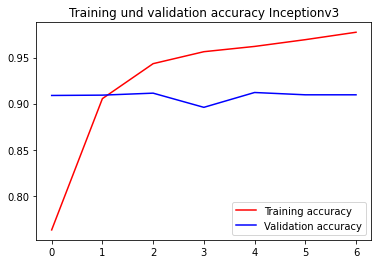

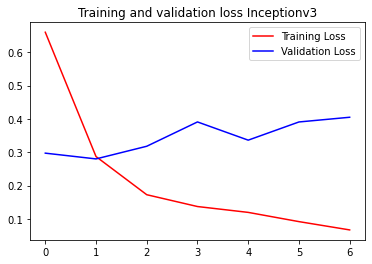

In [ ]:
acc = train_data.history['accuracy']
val_acc = train_data.history['val_accuracy']
loss = train_data.history['loss']
val_loss = train_data.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training und validation accuracy Inceptionv3')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss Inceptionv3')
plt.legend()

### 3.3) Visualisieren Sie die Architekturen der beiden Modelle


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

### 3.4) Plotten Sie für beide Modelle den Loss und die Accuracy über 10 Epochen
Beobachten Sie Anzeichen von Overfitting? Würden Sie das Modell für weitere Epochen trainieren wollen? Begründen Sie Ihre Antwort


In [ ]:
from IPython.display import HTML
HTML('<img src="pics\FirstCNNTensorboardAccuracy.png">')

In [ ]:
from IPython.display import HTML
HTML('<img src="pics\FirstCNNTensorboardLoss.png">')

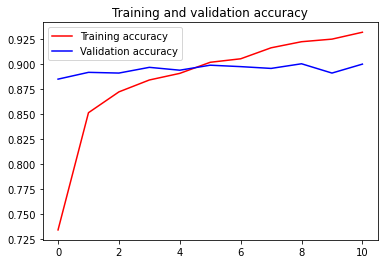

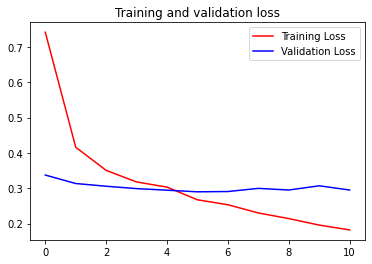

In [ ]:
acc = train_data.history['accuracy']
val_acc = train_data.history['val_accuracy']
loss = train_data.history['loss']
val_loss = train_data.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training und validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

## 4.) Evaluieren und interpretieren Sie das Netzwerk auf den Test-Daten (20)


### 4.1) Vergleichen Sie die Performanz beider neuronalen Modelle und die baseline. Welches Modell würden Sie produktiv einsetzen? Alle weiteren Analysen erfolgen auf dem, Ihrer Meinung nach, besseren (neuronalen) Modell


### 4.2) Schätzen Sie die Genauigkeit/Accuracy Ihrer Methode für jede Klasse separat, sowie für alle Klasse


In [110]:
from sklearn.metrics import classification_report

x_test = scaler.fit_transform(x_test.reshape(x_test.shape[0], -1))
x_test = x_test.reshape(x_test.shape[0], 150, 150, 3)
model = load_model('saved_models/Inceptionv3_Durchlauf1.h5')
# Make predictions on the validation data
y_pred = model.predict(x_test)
# Convert the predictions from one-hot encoded format to class labels
y_pred = np.argmax(y_pred, axis=1)
y_val = Y_test
# Print the classification report
print(classification_report(y_val, y_pred, target_names=class_labels,digits = 4))

94/94 [==============================] - 60s 618ms/step
              precision    recall  f1-score   support

   buildings     0.9373    0.8902    0.9131       437
      forest     0.9831    0.9831    0.9831       473
     glacier     0.8622    0.8434    0.8527       549
    mountain     0.8533    0.8566    0.8550       523
         sea     0.9336    0.9373    0.9354       510
      street     0.9002    0.9541    0.9264       501

    accuracy                         0.9091      2993
   macro avg     0.9116    0.9108    0.9109      2993
weighted avg     0.9093    0.9091    0.9089      2993



              precision    recall  f1-score      support
buildings      0.937349  0.890160  0.913146   437.000000
forest         0.983087  0.983087  0.983087   473.000000
glacier        0.862197  0.843352  0.852670   549.000000
mountain       0.853333  0.856597  0.854962   523.000000
sea            0.933594  0.937255  0.935421   510.000000
street         0.900188  0.954092  0.926357   501.000000
accuracy       0.909121  0.909121  0.909121     0.909121
macro avg      0.911625  0.910757  0.910940  2993.000000
weighted avg   0.909251  0.909121  0.908946  2993.000000


<AxesSubplot:>

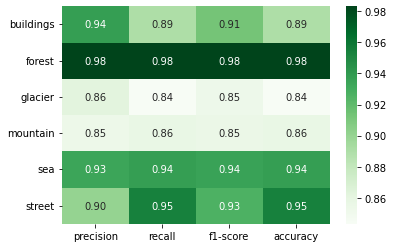

In [111]:
from copy import deepcopy
classification_rep = classification_report(y_val, y_pred, target_names=class_labels,digits = 4,output_dict=True)
report_df = pd.DataFrame(classification_rep).transpose()
cm = confusion_matrix(y_val, y_pred)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
class_accuracies = np.append(class_accuracies,[0,0,0])
cl = deepcopy(class_labels)
print(report_df)

report_df["accuracy"] = class_accuracies
report_df = report_df[report_df.index.isin(cl)]

sns.heatmap(report_df[["precision", "recall", "f1-score","accuracy"]], annot=True, cmap='Greens', fmt='.2f', xticklabels=["precision", "recall", "f1-score","accuracy"], yticklabels=cl)

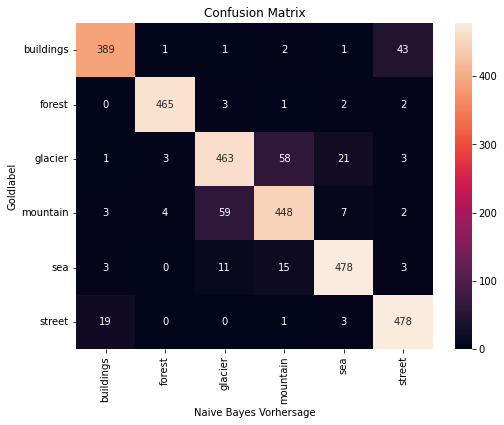

In [116]:

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Naive Bayes Vorhersage')
plt.ylabel('Goldlabel')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels,rotation='vertical')
ax.yaxis.set_ticklabels(class_labels,rotation='horizontal')
plt.show()

In [117]:
model = load_model('saved_models/MobileNetv2_Durchlauf1.h5')
# Make predictions on the validation data
y_pred = model.predict(x_test)
# Convert the predictions from one-hot encoded format to class labels
y_pred = np.argmax(y_pred, axis=1)
y_val = Y_test
# Print the classification report
print(classification_report(y_val, y_pred, target_names=class_labels,digits = 4))

94/94 [==============================] - 33s 340ms/step
              precision    recall  f1-score   support

   buildings     0.9260    0.9451    0.9354       437
      forest     0.9811    0.9873    0.9842       473
     glacier     0.8301    0.8634    0.8464       549
    mountain     0.8442    0.8394    0.8418       523
         sea     0.9446    0.9020    0.9228       510
      street     0.9473    0.9321    0.9396       501

    accuracy                         0.9088      2993
   macro avg     0.9122    0.9115    0.9117      2993
weighted avg     0.9096    0.9088    0.9090      2993



              precision    recall  f1-score      support
buildings      0.926009  0.945080  0.935447   437.000000
forest         0.981092  0.987315  0.984194   473.000000
glacier        0.830123  0.863388  0.846429   549.000000
mountain       0.844231  0.839388  0.841802   523.000000
sea            0.944559  0.901961  0.922768   510.000000
street         0.947262  0.932136  0.939638   501.000000
accuracy       0.908787  0.908787  0.908787     0.908787
macro avg      0.912212  0.911545  0.911713  2993.000000
weighted avg   0.909554  0.908787  0.909000  2993.000000


<AxesSubplot:>

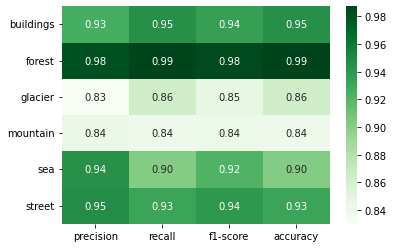

In [104]:

classification_rep = classification_report(y_val, y_pred, target_names=class_labels,digits = 4,output_dict=True)
report_df = pd.DataFrame(classification_rep).transpose()
cm = confusion_matrix(y_val, y_pred)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
class_accuracies = np.append(class_accuracies,[0,0,0])
cl = deepcopy(class_labels)
print(report_df)

report_df["accuracy"] = class_accuracies
report_df = report_df[report_df.index.isin(cl)]

sns.heatmap(report_df[["precision", "recall", "f1-score","accuracy"]], annot=True, cmap='Greens', fmt='.2f', xticklabels=["precision", "recall", "f1-score","accuracy"], yticklabels=cl)

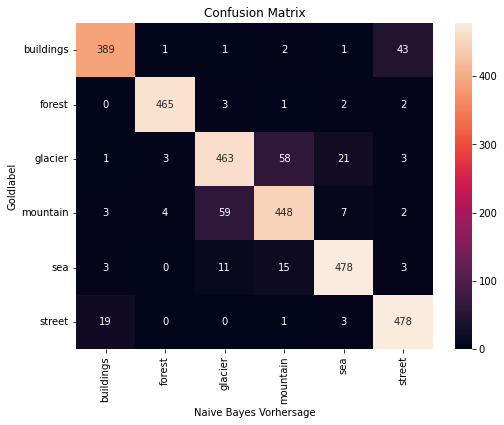

In [118]:

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Naive Bayes Vorhersage')
plt.ylabel('Goldlabel')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels,rotation='vertical')
ax.yaxis.set_ticklabels(class_labels,rotation='horizontal')
plt.show()

In [120]:
model = load_model('saved_models/NormalCNN.h5')
# Make predictions on the validation data
y_pred = model.predict(x_test)
# Convert the predictions from one-hot encoded format to class labels
y_pred = np.argmax(y_pred, axis=1)
y_val = Y_test
classification_rep = classification_report(y_val, y_pred, target_names=class_labels,digits = 4)



94/94 [==============================] - 15s 160ms/step


              precision    recall  f1-score      support
buildings      0.804455  0.743707  0.772889   437.000000
forest         0.883365  0.976744  0.927711   473.000000
glacier        0.787934  0.785064  0.786496   549.000000
mountain       0.769797  0.799235  0.784240   523.000000
sea            0.818725  0.805882  0.812253   510.000000
street         0.835443  0.790419  0.812308   501.000000
accuracy       0.816238  0.816238  0.816238     0.816238
macro avg      0.816620  0.816842  0.815983  2993.000000
weighted avg   0.815458  0.816238  0.815142  2993.000000


<AxesSubplot:>

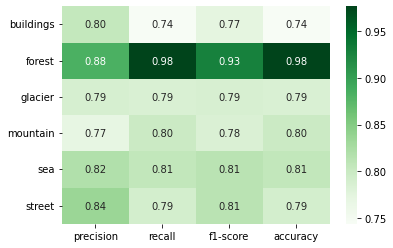

In [121]:
classification_rep = classification_report(y_val, y_pred, target_names=class_labels,digits = 4,output_dict=True)
report_df = pd.DataFrame(classification_rep).transpose()
cm = confusion_matrix(y_val, y_pred)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
class_accuracies = np.append(class_accuracies,[0,0,0])
cl = deepcopy(class_labels)
print(report_df)

report_df["accuracy"] = class_accuracies
report_df = report_df[report_df.index.isin(cl)]

sns.heatmap(report_df[["precision", "recall", "f1-score","accuracy"]], annot=True, cmap='Greens', fmt='.2f', xticklabels=["precision", "recall", "f1-score","accuracy"], yticklabels=cl)

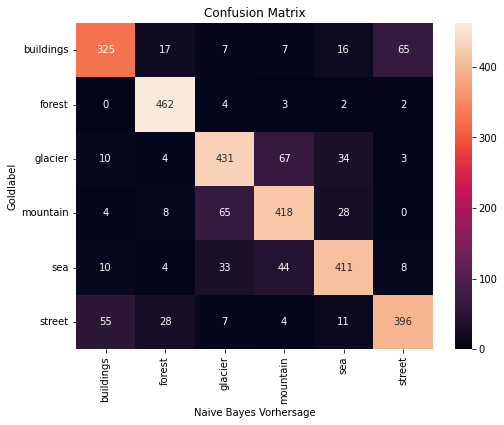

In [124]:

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Naive Bayes Vorhersage')
plt.ylabel('Goldlabel')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels,rotation='vertical')
ax.yaxis.set_ticklabels(class_labels,rotation='horizontal')
plt.show()

### 4.3) Erzeugen Sie eine Confusion Matrix 


In [ ]:
# Code

### 4.4) Interpretation der Confusion-Matrix. Welche Klasse ist am schwersten zu klassifizieren und mit welchen Klassen wird sie oft „verwechselt“


## 5.) Geben Sie für ein ausgewähltes Testbild (example-150.png) die Klassenwahrscheinlichkeiten aus (5 Punkte)


### 5.1) Wenden Sie Ihr Modell auf das Testbild (example-150.png) an.
Plotten Sie das ausgewählte Bild und nennen Sie die 6 Wahrscheinlichkeiten der einzelnen Bildklassen


In [138]:
image = cv2.imread("pics/glacier/150.jpg") 
im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [150]:
im_rgb = scaler.fit_transform(im_rgb.reshape(im_rgb.shape[0], -1))
im_rgb = im_rgb.reshape(1, 150, 150, 3)
im_rgb

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]])

In [158]:
predictions = model.predict(im_rgb)
dict = {}
for i,ele in enumerate(class_labels):
    dict[ele] = str(round((predictions[0][i]*100),3))+" %"
dict

1/1 [==============================] - 0s 38ms/step


{'buildings': '0.03 %',
 'forest': '3.988 %',
 'glacier': '2.098 %',
 'mountain': '67.298 %',
 'sea': '24.905 %',
 'street': '1.681 %'}

## 6.) Trainieren Sie für jede der beiden neuronalen Architekturen mehrere Modelle (20 Punkte)



### 6.1) Definieren Sie (mindestens) 5 random seeds 


In [21]:

seeds = []

for i in range(0,5):
    seeds.append(random.randint(0,(2**32-1)))
seeds

[3397748923, 943827110, 3497719044, 187570877, 3277143702]

In [22]:
seeds = [2005225354, 450796038, 3416329015, 585690048, 1797869589]

### 6.2) Trainieren Sie für jeden random seed die Modelle (3.1 und 3.2)


In [23]:
scaler = MinMaxScaler()
x_test, Y_test = get_images('Data/test/')
x_test = np.array(x_test) 
Y_test = np.array(Y_test)
x_test = scaler.fit_transform(x_test.reshape(x_test.shape[0], -1))
x_test = x_test.reshape(x_test.shape[0], 150, 150, 3)

In [10]:
from keras.callbacks import ProgbarLogger
from sklearn.preprocessing import StandardScaler

logger = ProgbarLogger()
scaler = StandardScaler()

x_train_ = scaler.fit_transform(x_train_.reshape(x_train_.shape[0], -1))
x_train_ = x_train_.reshape(x_train_.shape[0], 150, 150, 3)
y_train_ = to_categorical(y_train_)

x_dev_ = scaler.fit_transform(x_dev_.reshape(x_dev_.shape[0], -1))
x_dev_ = x_dev_.reshape(x_dev_.shape[0], 150, 150, 3)
y_dev_ = to_categorical(y_dev_)

NameError: name 'x_train_' is not defined

In [38]:
import tensorflow as tf 
def train_mobileNet_with_seed(seed:int):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    input_shape = (150, 150, 3)

    base_model = MobileNetV2(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    predictions = Dense(len(class_labels), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=2,validation_data=(x_dev_, y_dev_),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')],shuffle=False)

    return model, train_data

In [47]:
from keras.applications import InceptionV3
def train_inception_with_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

    input_shape = (150, 150, 3)

    base_model = InceptionV3(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape
                            )

    for layer in base_model.layers[-3:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    predictions = Dense(len(class_labels), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=2,validation_data=(x_dev_, y_dev_),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')],
    shuffle=False)
    return model, train_data


In [48]:
acc_dict = {}
for seed in seeds:
    model, train_data = train_inception_with_seed(seed)
    model.save(f"saved_models/seed_models/Inceptionv3_seed_{seed}.h5", include_optimizer=True)
    print(train_data.history['val_accuracy'][-1])
    acc_dict["Inceptionv3_seed_{seed}"] = train_data.history['val_accuracy'][-1]
print(acc_dict)

Epoch 1/2
350/350 [==============================] - 1594s 5s/step - loss: 0.6341 - accuracy: 0.7686 - val_loss: 0.3522 - val_accuracy: 0.8863
Epoch 2/2
350/350 [==============================] - 1531s 4s/step - loss: 0.2207 - accuracy: 0.9256 - val_loss: 0.3097 - val_accuracy: 0.9089
0.9088634848594666
Epoch 1/2
350/350 [==============================] - 1567s 4s/step - loss: 0.6301 - accuracy: 0.7749 - val_loss: 0.3874 - val_accuracy: 0.8806
Epoch 2/2
350/350 [==============================] - 1496s 4s/step - loss: 0.2164 - accuracy: 0.9309 - val_loss: 0.3278 - val_accuracy: 0.9139
0.9138670563697815
Epoch 1/2
350/350 [==============================] - 1568s 4s/step - loss: 0.6367 - accuracy: 0.7640 - val_loss: 0.3613 - val_accuracy: 0.8853
Epoch 2/2
350/350 [==============================] - 1500s 4s/step - loss: 0.2206 - accuracy: 0.9257 - val_loss: 0.3499 - val_accuracy: 0.9010
0.9010007381439209
Epoch 1/2
350/350 [==============================] - 1642s 5s/step - loss: 0.6232 - a

In [42]:
train_data.history['val_accuracy'][-1]

[0.8788420557975769, 0.8856325745582581]

In [50]:
import pickle
with open("saved_models/seed_models/pickle_data/accuracy_dict_train_incep.pkl", "wb") as f:
    pickle.dump(acc_dict, f)

### 6.3) Evaluieren Sie alle Modelle auf den Testdaten 


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_test, Y_test = get_images('Data/test/')
x_test = np.array(x_test) 
Y_test = np.array(Y_test)
x_test = scaler.fit_transform(x_test.reshape(x_test.shape[0], -1))
x_test = x_test.reshape(x_test.shape[0], 150, 150, 3)


In [15]:
import os
from fnmatch import fnmatch
from sklearn.metrics import accuracy_score
folder_path = 'saved_models/seed_models'
pattern = '*MobileNet*'
pattern2 = '*Inceptionv3*'
accuracy_dict = {}
accuracy_dict["MobileNet"] = []
accuracy_dict["Inceptionv3"] = []
for file_name in os.listdir(folder_path):
    if fnmatch(file_name, pattern) or fnmatch(file_name, pattern2):
        file_path = os.path.join(folder_path, file_name)
        model = load_model(file_path)
        y_pred = model.predict(x_test)
        y_pred = np.argmax(y_pred, axis=1)
        test_acc = accuracy_score(Y_test, y_pred)
        if fnmatch(file_name, pattern):
            accuracy_dict["MobileNet"].append(test_acc)
        if fnmatch(file_name, pattern2):
            accuracy_dict["Inceptionv3"].append(test_acc)
        print(test_acc)

94/94 [==============================] - 61s 626ms/step
0.8519879719345138
94/94 [==============================] - 71s 731ms/step
0.8496491814233211
94/94 [==============================] - 70s 684ms/step
0.8422986969595724
94/94 [==============================] - 68s 700ms/step
0.8322753090544605
94/94 [==============================] - 72s 733ms/step
0.8205813564984965
94/94 [==============================] - 37s 378ms/step
0.8152355496157702
94/94 [==============================] - 39s 404ms/step
0.8249248245907117
94/94 [==============================] - 38s 390ms/step
0.78149014366856
94/94 [==============================] - 38s 383ms/step
0.8356164383561644
94/94 [==============================] - 39s 393ms/step
0.8025392582692951


In [16]:
accuracy_dict

{'MobileNet': [0.8152355496157702,
  0.8249248245907117,
  0.78149014366856,
  0.8356164383561644,
  0.8025392582692951],
 'Inceptionv3': [0.8519879719345138,
  0.8496491814233211,
  0.8422986969595724,
  0.8322753090544605,
  0.8205813564984965]}

### 6.4) Plotten Sie die Verteilungen (Accuracy) der beiden Modelle als Boxplot oder Violin plot


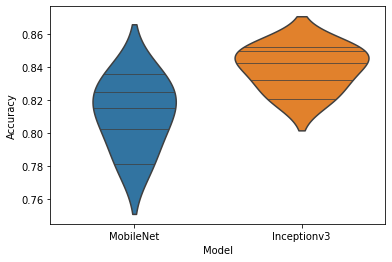

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame.from_dict(accuracy_dict)
sns.violinplot(data=df, inner="stick")
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

### 6.5) Interpretieren Sie die Ergebnisse. Welches der beiden Modelle ist besser?


## 7.) Bauen Sie ein (einfaches) Ensemble  (20 Punkte)


### 7.1 Implementieren Sie ein einfaches majority-voting Ensemble (Empfehlung nehmen Sie die Modelle aus 6)

In [ ]:
from fnmatch import fnmatch
folder_path = 'saved_models/seed_models'
pattern = '*MobileNet*'
pattern2 = '*Inceptionv3*'
models = []
for file_name in os.listdir(folder_path):
    if fnmatch(file_name, pattern) or fnmatch(file_name, pattern2):
        file_path = os.path.join(folder_path, file_name)
        model = load_model(file_path)
        models.append(model)


In [ ]:
def ensemble_predict(models, test_data):
    predictions = []
    for model in models:
        predictions.append(model.predict(test_data))
    return predictions


In [ ]:
ensemble_predictions = ensemble_predict(models, x_test)

In [ ]:

def majority_voting_ensemble(predictions):
    ensemble_predictions = []
    for i in range(len(predictions[0])):
        ensemble_predictions.append(np.argmax(np.bincount([np.argmax(pred[i]) for pred in predictions])))
    return ensemble_predictions

ensemble_predictions = majority_voting_ensemble(ensemble_predictions)

### 7.2) Evaluieren Sie den Ensemble-Klassifikator auf dem Test-set

In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, ensemble_predictions)
print("Ensemble accuracy:", accuracy)

Ensemble accuracy: 0.8663548279318409


In [ ]:
ensemble_predictions = ensemble_predict(models, x_train_)
ensemble_predictions = np.array(ensemble_predictions)
ensemble_predictions = ensemble_predictions.T

model = Sequential()
model.add(Dense(64, input_dim=ensemble_predictions.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(class_labels), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(ensemble_predictions, y_train_, epochs=50, batch_size=32)

350/350 [==============================] - 270s 758ms/step


MemoryError: Unable to allocate 2.81 GiB for an array with shape (11188, 150, 150, 3) and data type float32

In [ ]:
# First, make predictions using the ensemble on the test data
ensemble_predictions_test = ensemble_predict(models, x_test)

# Convert the ensemble predictions to a 2D array
ensemble_predictions_test = np.array(ensemble_predictions_test)
ensemble_predictions_test = ensemble_predictions_test.T

# Make predictions using the stacking ensemble model
predictions = model.predict(ensemble_predictions_test)

# Convert the predictions to class labels
predictions = np.argmax(predictions, axis=1)

# Compare the predictions with the true labels
accuracy = accuracy_score(y_test, predictions)
print("Stacking ensemble accuracy:", accuracy)

### 7.3 Wie ist die Performanz des Ensembles im Vergleich zu den einzelnen Modellen? Welches Modell würden Sie am Ende einsetzen? Begründen Sie Ihre Antwort.

## 8.) Bitte schätzen Sie den benötigten Zeitaufwand für die Übung (optional)

Für die Übungen habe ich **XY Stunden** benötigt. Gerne auch detailliertere Abschätzungen  (pro Übung). 

In [51]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
def big_model(seed:int):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

    input_shape = (150, 150, 3)

    base_model = InceptionV3(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape)

    # Freeze all layers except the last 3
    for layer in base_model.layers[:-3]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    predictions = Dense(len(class_labels), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(x_train_, y_train_, batch_size=32)
    val_generator = val_datagen.flow(x_dev_, y_dev_, batch_size=32)

    train_data = model.fit_generator(train_generator,
                                    steps_per_epoch=len(x_train_) / 32,
                                    epochs=50,
                                    validation_data=val_generator,
                                    validation_steps=len(x_dev_) / 32,
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=3), TensorBoard(log_dir='./logs')])

    return model, train_data

In [57]:
model, train_data = big_model(seed=42)

KeyboardInterrupt: 

In [53]:
model.save(f"saved_models/seed_models/big_model.h5", include_optimizer=True)

In [56]:
train_data.history["val_accuracy"]

[0.5314510464668274,
 0.6479628086090088,
 0.7051465511322021,
 0.7340958118438721,
 0.7526804804801941,
 0.7726947665214539,
 0.783059298992157,
 0.7869907021522522,
 0.800214409828186,
 0.7984274625778198,
 0.8062902092933655,
 0.8073623776435852,
 0.8145103454589844,
 0.8202287554740906,
 0.8216583132743835,
 0.8248749375343323,
 0.8280915021896362,
 0.827734112739563,
 0.8238027095794678,
 0.8305932879447937,
 0.8341672420501709]

In [59]:
from keras.applications import InceptionV3
def train_inception_with_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

    input_shape = (150, 150, 3)

    base_model = InceptionV3(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape
                            )

    for layer in base_model.layers[-5:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    predictions = Dense(len(class_labels), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=6,validation_data=(x_dev_, y_dev_),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')],
    shuffle=False)
    return model, train_data
model, train_data = train_inception_with_seed(450796038)

Epoch 1/6
350/350 [==============================] - 1695s 5s/step - loss: 0.6301 - accuracy: 0.7749 - val_loss: 0.3874 - val_accuracy: 0.8806
Epoch 2/6
350/350 [==============================] - 1748s 5s/step - loss: 0.2164 - accuracy: 0.9309 - val_loss: 0.3278 - val_accuracy: 0.9139
Epoch 3/6
350/350 [==============================] - 1712s 5s/step - loss: 0.0988 - accuracy: 0.9659 - val_loss: 0.4796 - val_accuracy: 0.8924
Epoch 4/6
350/350 [==============================] - 1729s 5s/step - loss: 0.0767 - accuracy: 0.9751 - val_loss: 0.5542 - val_accuracy: 0.9064
Epoch 5/6
350/350 [==============================] - 1768s 5s/step - loss: 0.0836 - accuracy: 0.9740 - val_loss: 0.4377 - val_accuracy: 0.8999
Epoch 6/6
350/350 [==============================] - 1714s 5s/step - loss: 0.0786 - accuracy: 0.9761 - val_loss: 0.4649 - val_accuracy: 0.9031


In [60]:
model.save("saved_models/Inceptionv3_6epochs.h5", include_optimizer=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_test, Y_test = get_images('Data/test/')
x_test = np.array(x_test) 
Y_test = np.array(Y_test)
x_test = scaler.fit_transform(x_test.reshape(x_test.shape[0], -1))
x_test = x_test.reshape(x_test.shape[0], 150, 150, 3)

In [6]:
model = load_model("saved_models/Inceptionv3_6epochs.h5")

In [7]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
test_acc = accuracy_score(Y_test, y_pred)

94/94 [==============================] - 58s 587ms/step


In [8]:
test_acc

0.8346140995656532

In [19]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import BatchNormalization
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_, y_train_, batch_size=32, epochs=2, validation_data=(x_dev_, y_dev_))

Epoch 1/2
272/350 [======================>.......] - ETA: 8:15 - loss: 1.5075 - accuracy: 0.4077

In [ ]:
model.save("saved_models/resNet_3epochs.h5", include_optimizer=True)